In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

import torch

from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

In [3]:
MEMBER_TO_REFERRALS_FP = 'data/process/member_to_referrals.json'

In [4]:
def load_member_data(file_path: str) -> pd.DataFrame:
    """
    Load member data from a JSON file and convert it to a DataFrame

    Args:
        file_path (str) - The path to the JSON file

    Returns:
        data - The loaded data as a DataFrame
    """
    with open(file_path, 'r') as f:
        data = json.load(f)

    rows = [(name, referral) for name, referrals in data.items() for referral in referrals]

    member_df = pd.DataFrame(rows, columns = ['name', 'referral_received'])

    return member_df

In [5]:
member_df = load_member_data('data/process/member_to_referrals.json')

print(member_df.head())

        name                                  referral_received
0    allison  allison knows how to send an email that gets r...
1       noah  met because we both stayed late after a meetin...
2       noah  we only talked once at length but noah left su...
3       noah  ran into noah while lost in the CS building — ...
4  gabrielle  most beautiful combo of wit and work ethic — g...


In [6]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

embeddings = model.encode(
    member_df['referral_received'].tolist(), 
    convert_to_tensor = True,
    batch_size = 5,
    show_progress_bar = True
)

member_df['rr_embedding'] = [embedding.cpu().numpy() for embedding in embeddings]

print(member_df.head())

/Users/paul/opt/miniconda3/envs/env/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

        name                                  referral_received  \
0    allison  allison knows how to send an email that gets r...   
1       noah  met because we both stayed late after a meetin...   
2       noah  we only talked once at length but noah left su...   
3       noah  ran into noah while lost in the CS building — ...   
4  gabrielle  most beautiful combo of wit and work ethic — g...   

                                        rr_embedding  
0  [-0.023937242, 0.1229449, -0.03673235, 0.02765...  
1  [0.014586663, 0.08165126, -0.027110761, -0.010...  
2  [-0.031200906, 0.069543205, -0.01977467, -0.05...  
3  [0.0007096485, 0.052328512, -0.025854176, -0.0...  
4  [-0.034817625, 0.09657614, -0.0039321356, -0.0...  


In [25]:
grouped_embeddings = member_df.groupby('name')['rr_embedding']

mean_pooled_referral_embeddings = grouped_embeddings.mean().reset_index(name = 'mean_embedding')
referral_counts = grouped_embeddings.count().reset_index(name = 'referral_count')

print(mean_pooled_referral_embeddings, end = '\n\n')
print(referral_counts)

        name                                     mean_embedding
0    allison  [-0.023937242, 0.1229449, -0.03673235, 0.02765...
1      angie  [-0.014529911, 0.06296303, -0.024890486, 0.008...
2     connie  [-0.012152914, 0.03992878, -0.0175603, 0.02355...
3  gabrielle  [0.016208189, 0.050545562, 0.017669156, -0.011...
4       gina  [-0.025992667, 0.0259783, 0.005142337, 0.00215...
5       noah  [-0.0053015314, 0.06784099, -0.024246536, -0.0...

        name  referral_count
0    allison               1
1      angie               2
2     connie               1
3  gabrielle               2
4       gina               1
5       noah               3


In [39]:
names = mean_pooled_referral_embeddings['name'].tolist()
mean_embeddings = np.array(mean_pooled_referral_embeddings['mean_embedding'].tolist())

similarity_matrix = cosine_similarity(mean_embeddings)

similarity_df = pd.DataFrame(similarity_matrix, index = names, columns = names)
np.fill_diagonal(similarity_df.values, 0)

print(similarity_df)

            allison     angie    connie  gabrielle      gina      noah
allison    0.000000  0.459478  0.357982   0.362110  0.207494  0.215560
angie      0.459478  0.000000  0.431465   0.368029  0.315505  0.316788
connie     0.357982  0.431465  0.000000   0.247677  0.351149  0.212341
gabrielle  0.362110  0.368029  0.247677   0.000000  0.219118  0.205051
gina       0.207494  0.315505  0.351149   0.219118  0.000000  0.345351
noah       0.215560  0.316788  0.212341   0.205051  0.345351  0.000000
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


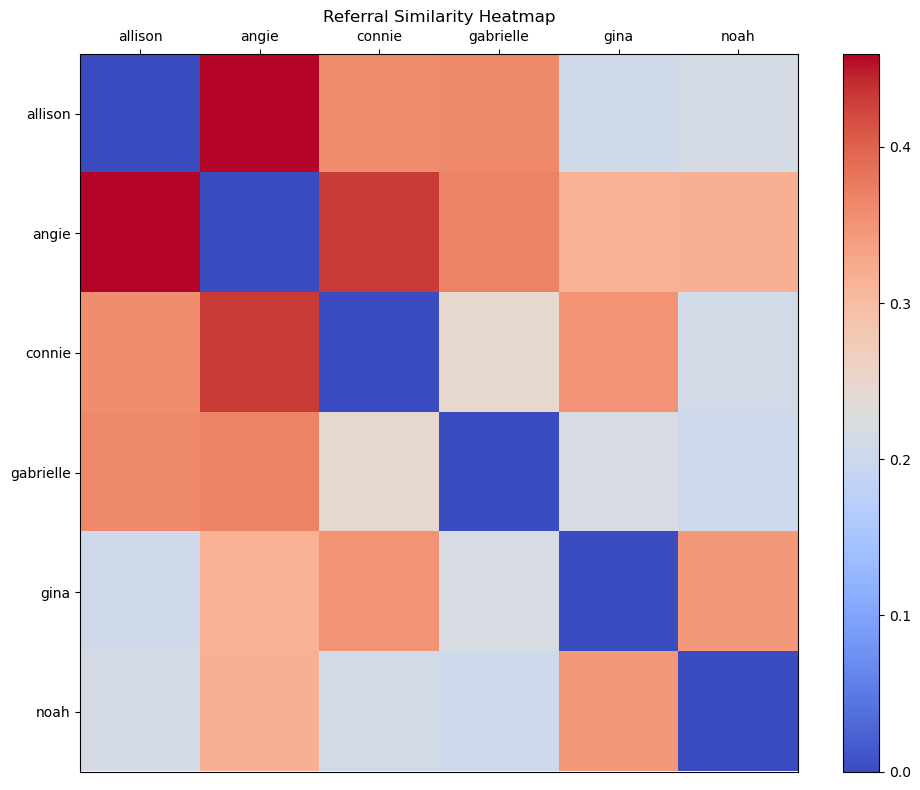

In [45]:
plt.figure(figsize = (10, 8))
plt.imshow(similarity_matrix, cmap = 'coolwarm')
plt.xticks(ticks = np.arange(len(names)), labels = names)
plt.yticks(ticks = np.arange(len(names)), labels = names)
plt.gca().xaxis.tick_top()
plt.title('Referral Similarity Heatmap')
plt.colorbar()
plt.tight_layout()
plt.savefig('data/process/referral_similarity_heatmap.png')
plt.show()